In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

# Synthetic dataset

In [3]:
np.random.seed(42)
n_samples = 10000

# === Numeric Features ===
feature_num1 = np.random.normal(loc=50, scale=10, size=n_samples)
feature_num2 = np.random.uniform(low=0, high=100, size=n_samples)

# === Categorical Features ===
cat1_choices = ['A', 'B', 'C']
cat2_choices = ['X', 'Y']
cat3_choices = ['Red', 'Green', 'Blue', 'Yellow']

feature_cat1 = np.random.choice(cat1_choices, size=n_samples).astype(object)
feature_cat2 = np.random.choice(cat2_choices, size=n_samples).astype(object)
feature_cat3 = np.random.choice(cat3_choices, size=n_samples).astype(object)

# === Target Variable ===
# Target is a noisy function of inputs + category encodings
target = (
    0.4 * np.nan_to_num(feature_num1)
    + 0.25 * feature_num2
    + np.where(feature_cat1 == 'A', 10, 0)
    + np.where(feature_cat2 == 'X', -5, 5)
    + np.random.normal(0, 5, size=n_samples)
)

# Inject outliers
outlier_indices = np.random.choice(n_samples, size=5, replace=False)
feature_num1[outlier_indices[:3]] = feature_num1[outlier_indices[:3]] + 80  # big positive outliers
feature_num2[outlier_indices[3:]] = feature_num2[outlier_indices[3:]] - 120  # big negative outliers

# Inject missing values
missing_indices = np.random.choice(n_samples, size=10, replace=False)
feature_num1[missing_indices[:5]] = np.nan
feature_cat2[missing_indices[5:]] = np.nan

# Combine into DataFrame
df = pd.DataFrame({
    'feature_num1': feature_num1,
    'feature_num2': feature_num2,
    'feature_cat1': feature_cat1,
    'feature_cat2': feature_cat2,
    'feature_cat3': feature_cat3,
    'target': target
})

# Display a sample
df.head(10)


,feature_num1,feature_num2,feature_cat1,feature_cat2,feature_cat3,target
0,54.967142,32.125517,C,Y,Green,41.243231
1,48.617357,10.301919,A,Y,Blue,43.383554
2,56.476885,7.180755,C,Y,Blue,32.790054
3,65.230299,9.427598,C,Y,Blue,32.322380
4,47.658466,58.286936,B,Y,Yellow,47.641281
5,47.658630,5.166218,C,X,Red,20.296309
6,65.792128,33.692687,A,X,Red,39.154831
7,57.674347,75.319970,B,X,Green,27.127514
8,45.305256,29.434817,C,X,Green,24.787135
9,55.425600,76.330808,B,X,Red,42.460479


# EDA
- Explore missing values
- Identify and visualize outliers

- Visualize predictive relationships:
    - Correlation matrix
    - Scatter plots (numeric vs. target)
    - Box plots (categorical vs. target)

### Missing values

In [4]:
missing_summary = df.isnull().sum()
missing_summary

feature_num1    5
feature_num2    0
feature_cat1    0
feature_cat2    5
feature_cat3    0
target          0
dtype: int64

In [5]:
df.feature_cat2.value_counts(dropna=False)

feature_cat2
Y      5100
X      4895
NaN       5
Name: count, dtype: int64

### check distributions of numeric features

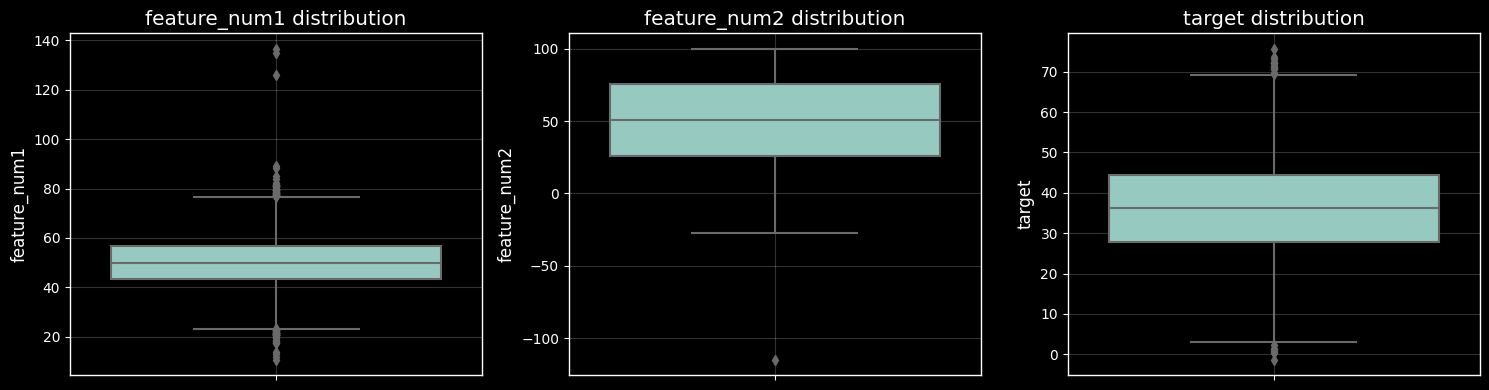

In [6]:
numeric_features = ['feature_num1', 'feature_num2', 'target']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(5 * len(numeric_features), 4))

for ax, col in zip(axes, numeric_features):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f'{col} distribution')
    ax.set_ylabel(col); ax.grid(alpha=0.2)

plt.tight_layout()

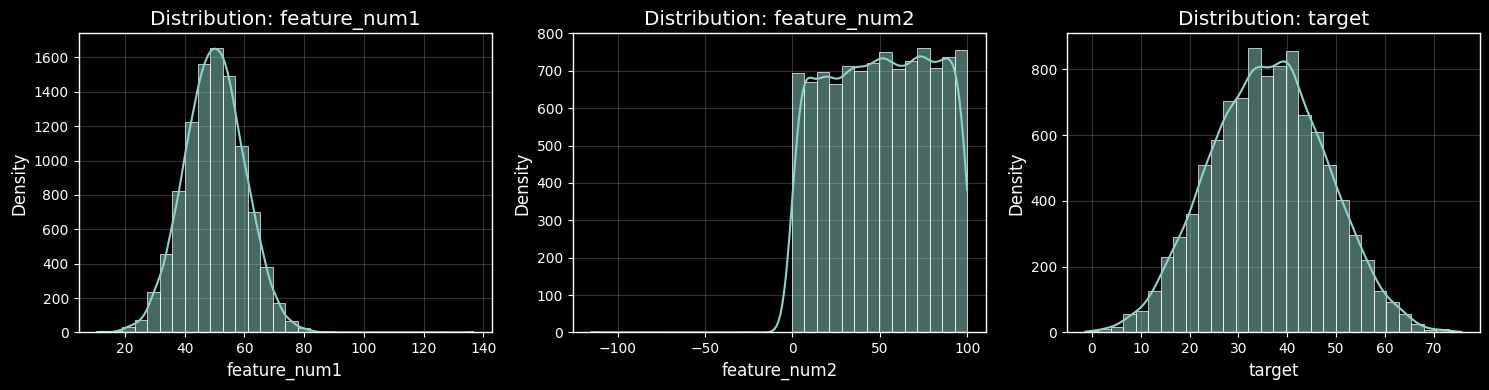

In [7]:
numeric_features = ['feature_num1', 'feature_num2', 'target']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(5 * len(numeric_features), 4))

for ax, col in zip(axes, numeric_features):
    sns.histplot(df[col], kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution: {col}')
    ax.set_ylabel('Density'); ax.grid(alpha=0.2)

plt.tight_layout()

### Check outliers of numeric features
- can either remove or winsorize depending on application

In [8]:
numeric_features = ['feature_num1', 'feature_num2', 'target']

# Compute z-scores manually
z_scores = np.abs((df[numeric_features] - df[numeric_features].mean()) / df[numeric_features].std())

# Count outliers (Z > 3)
outliers = (z_scores > 3).sum()
print("Outliers (Z > 3):")
print(outliers)

Outliers (Z > 3):
feature_num1    29
feature_num2     1
target           9
dtype: int64


### Check correlation matrix

In [9]:
# Correlation matrix for numeric variables
numeric_features = ['feature_num1', 'feature_num2', 'target']
corr = df[numeric_features].corr()
corr

,feature_num1,feature_num2,target
feature_num1,1.000000,-0.002677,0.328805
feature_num2,-0.002677,1.000000,0.610222
target,0.328805,0.610222,1.000000


> if you want to include categoricals you have to one hot encode them (oridnal would confuse output)

In [10]:
# Define categorical and numeric columns
categorical_features = ['feature_cat1', 'feature_cat2', 'feature_cat3']
numeric_features = ['feature_num1', 'feature_num2', 'target']

# One-hot encode the categoricals
df_onehot = pd.get_dummies(df[categorical_features], drop_first=False)

# Combine with numeric features
df_encoded = pd.concat([df[numeric_features], df_onehot], axis=1)

# Compute correlation matrix
corr_matrix = df_encoded.corr()
# only need to see the ones correlated with the target (its a big matrix otherwise)
corr_matrix['target']

feature_num1           0.328805
feature_num2           0.610222
target                 1.000000
feature_cat1_A         0.383294
feature_cat1_B        -0.183896
feature_cat1_C        -0.199054
feature_cat2_X        -0.433344
feature_cat2_Y         0.432872
feature_cat3_Blue     -0.009187
feature_cat3_Green    -0.010051
feature_cat3_Red       0.009121
feature_cat3_Yellow    0.010083
Name: target, dtype: float64

### Check predictive power of the features

> numeric - scatter plots

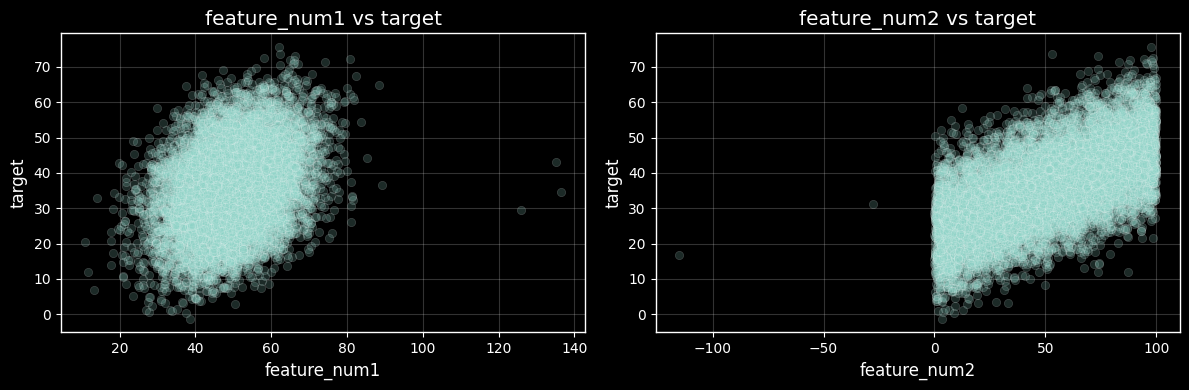

In [11]:
numeric_features = ['feature_num1', 'feature_num2']
target_col = 'target'

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(6 * len(numeric_features), 4))

for ax, col in zip(axes, numeric_features):
    sns.scatterplot(data=df, x=col, y=target_col, ax=ax, alpha=0.2)
    ax.set_title(f'{col} vs {target_col}')
    ax.set_xlabel(col); ax.set_ylabel(target_col); ax.grid(alpha=0.2)

plt.tight_layout()

> categoricals

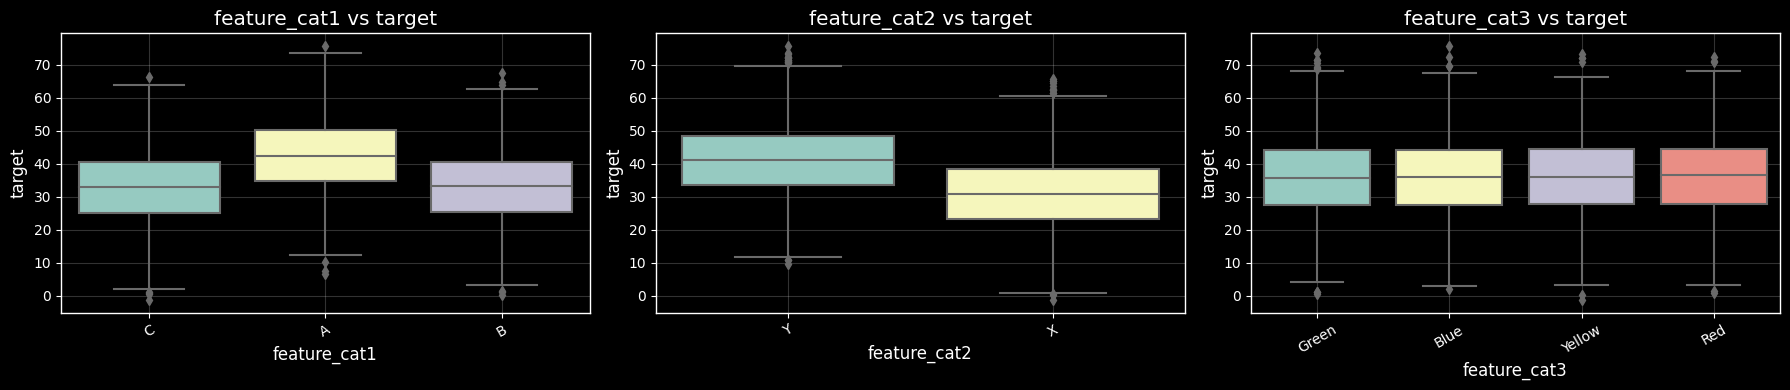

In [12]:
categorical_features = ['feature_cat1', 'feature_cat2', 'feature_cat3']
target_col = 'target'

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(6 * len(categorical_features), 4))

for ax, col in zip(axes, categorical_features):
    sns.boxplot(data=df, x=col, y=target_col, ax=ax)
    ax.set_title(f'{col} vs {target_col}')
    ax.set_xlabel(col)
    ax.set_ylabel(target_col)
    ax.tick_params(axis='x', rotation=30)
    ax.grid(alpha=0.2)

plt.tight_layout()

# Prepare for Training

I have a class that runs a train test split twice to give 3 groups. It then creates a category dtype for each of the cat cols and does nothing with missing values because xgboost handles that innately

In [101]:
from xgb_dset import XgboostDataset

dset = XgboostDataset(df, targ_col='target', id_cols=[])
dset.prep_for_tuning(split_type='temporal', p_train=0.8, p_valid=0.1)
dset.prep_for_final_training()

# Check sizes
print(f"Train: {len(dset.X_train)} samples")
print(f"Validation: {len(dset.X_valid)} samples")
print(f"Test: {len(dset.X_test)} samples")

Train: 8000 samples
Validation: 1000 samples
Test: 1000 samples


# Tune and Train

### Tune with optuna

In [102]:
from xgb_optuning import XGBoostOptunaTuner

tuner = XGBoostOptunaTuner(dset.X_train, dset.y_train, dset.X_valid, dset.y_valid, problem_type='regression')
study = tuner.optimize(total_tune_time=10, print_secs=10)

print(tuner.tuned_params)

Elapsed: 11.0sec | Iteration #6
{'max_depth': 11, 'learning_rate': 0.06054365855469246, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'lambda': 8.123245085588687, 'min_child_weight': 17.151524893607167, 'n_estimators': 121}


### Retrain final model

In [107]:
from xgboost import XGBRegressor
from ml_evals import ContinuousEvals

# Wrap the model as an XGBRegressor from sklearn
xgb_model = XGBRegressor(**tuner.training_params) # enable cats and hist already included
xgb_model.fit(dset.X_trainvalid, dset.y_trainvalid) 

# predict on test set
preds_test = xgb_model.predict(dset.X_test)
preds_train = xgb_model.predict(dset.X_trainvalid)

# Evaluate
train_evals = ContinuousEvals(dset.y_trainvalid, preds_train)
test_evals  = ContinuousEvals(dset.y_test, preds_test)

print('train')
display(train_evals.assemble_results_df())
print('test')
display(test_evals.assemble_results_df())

train


,rmse,rmse_over_mean,mae,mae_over_mean,ave_bias,total_bias
0,4.69884,0.130323,3.732128,0.103511,-0.025724,-231.512171


test


,rmse,rmse_over_mean,mae,mae_over_mean,ave_bias,total_bias
0,5.245208,0.143553,4.186581,0.11458,-0.094206,-94.205754


# Feature importances
- 'gain': average improvement in loss when the feature is used in a split (most informative).

- 'weight': number of times a feature is used in splits (can overvalue repeated but weak features).

- 'cover': average coverage (number of samples affected) per split involving the feature.

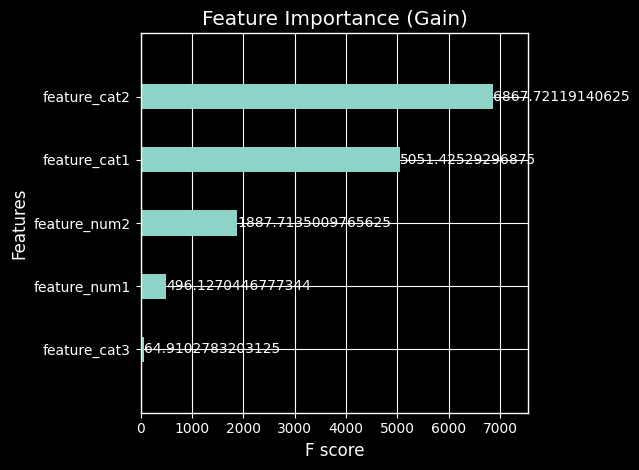

In [60]:
import xgboost as xgb

# Assign feature names to the booster (for plotting)
xgb_model.feature_names = list(dset.X_train.columns)

# Plot importance (by gain, cover, or weight)
xgb.plot_importance(
    xgb_model,
    importance_type='gain',   # ['gain','weight', 'cover']
    max_num_features=10,      
    height=0.4
)
plt.title("Feature Importance (Gain)")
plt.tight_layout()

# Shap

- each feature’s global impact on the prediction distribution.

- Color encodes the feature value (low = blue, high = red).

- Horizontal axis is the SHAP value: how much a feature contributes (positively or negatively) to the prediction.

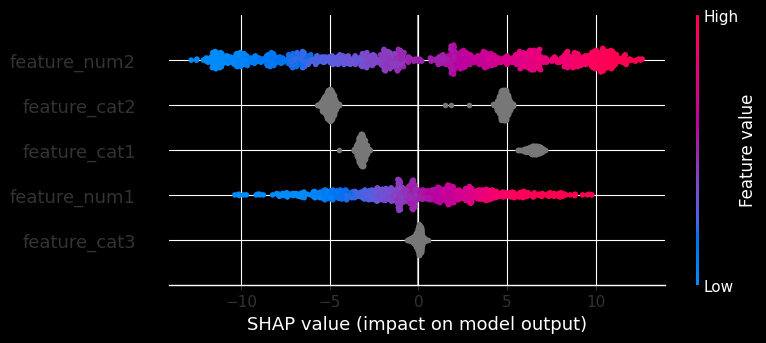

In [61]:
import shap

# Load JS visualization support
shap.initjs()

# Use TreeExplainer for XGBoost model
explainer = shap.Explainer(xgb_model)

# Compute SHAP values on the test set
shap_values = explainer(dset.X_test)

# Convert feature names for SHAP plots
shap_values.feature_names = list(dset.X_test.columns)

# Summary plot (global importance)
shap.plots.beeswarm(shap_values, max_display=10)

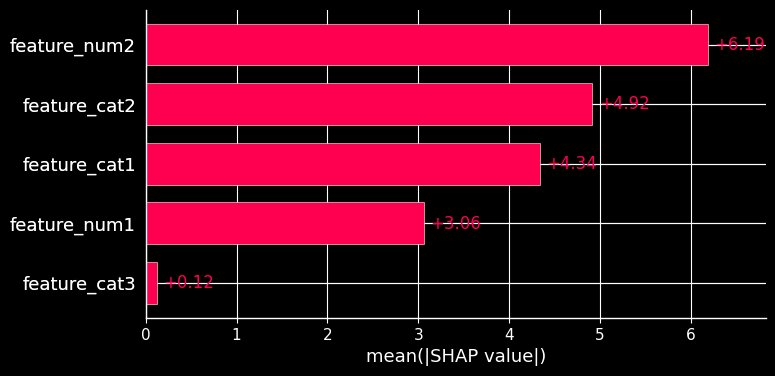

In [67]:
# Bar plot — global mean absolute SHAP value for each feature
shap.plots.bar(shap_values, max_display=10);


> shap pdp see https://docs.google.com/document/d/1YolTNjNTICJn7fNCx1-EB0Z2DoRVbRt-Wk4RDT8xceU/edit?tab=t.0#heading=h.ilo62hh4vx

/home/sfronczak/miniconda3/lib/python3.10/site-packages/shap/plots/_scatter.py:452: RuntimeWarning: invalid value encountered in greater
  min_dist = np.min(diffs[diffs > 1e-8])


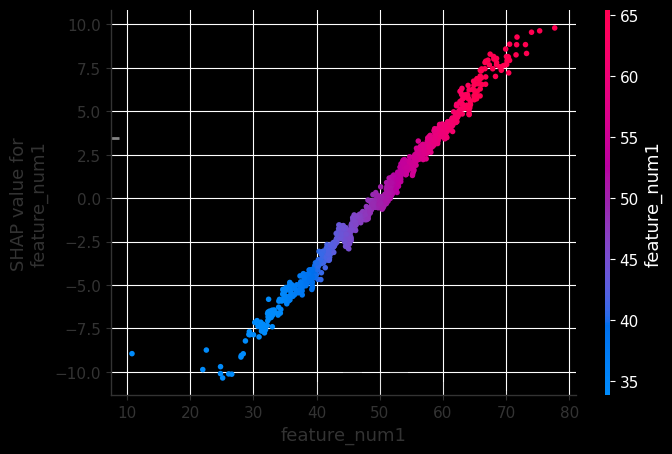

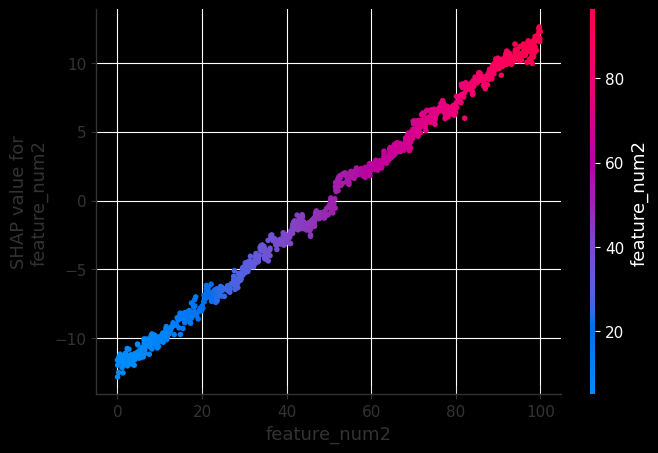

In [68]:
for col in numeric_features:
    shap.plots.scatter(shap_values[:, col], color=shap_values[:, col])

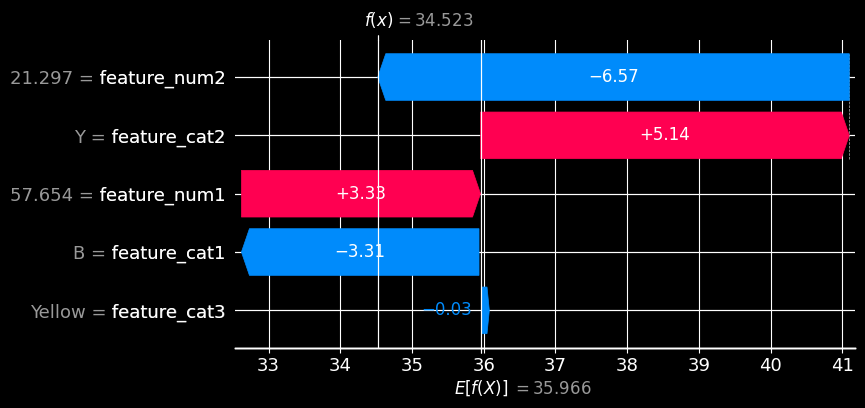

In [69]:
# Example: explanation for the first test instance
shap.plots.waterfall(shap_values[0])

In [70]:
for col in categorical_features:
    print(f"Category mapping for '{col}':")
    print(dict(enumerate(dset.X_test[col].cat.categories)))
    print()

Category mapping for 'feature_cat1':
{0: 'A', 1: 'B', 2: 'C'}

Category mapping for 'feature_cat2':
{0: 'X', 1: 'Y'}

Category mapping for 'feature_cat3':
{0: 'Blue', 1: 'Green', 2: 'Red', 3: 'Yellow'}



# Partial dependence plots (sklearn)

PDPs work best for features with a monotonic or linear influence, though they can still be informative for non-linear ones.

For categorical variables, PDPs assume ordinal relationships (because we encoded them that way). For interpretability, be cautious if the encoding does not represent meaningful order.

See here for explanation : https://docs.google.com/document/d/1YolTNjNTICJn7fNCx1-EB0Z2DoRVbRt-Wk4RDT8xceU/edit?tab=t.0#heading=h.ilo62hh4vx

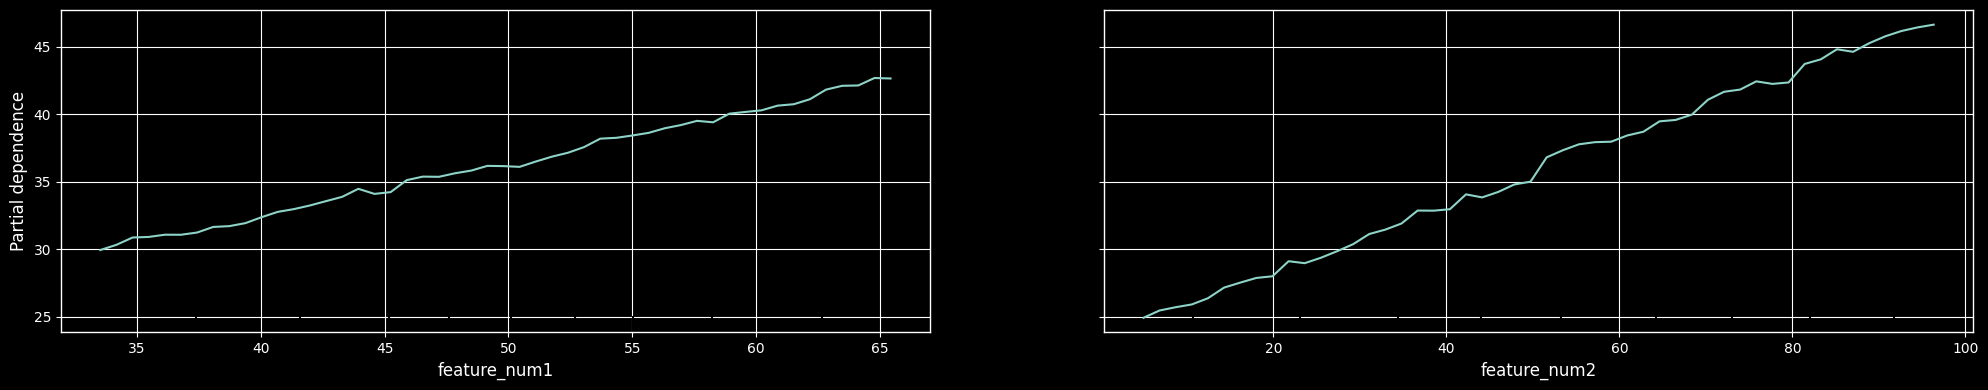

In [71]:
from sklearn.inspection import PartialDependenceDisplay


# Plot PDPs for all features
fig, ax = plt.subplots(figsize=(20, 4))
PartialDependenceDisplay.from_estimator(
    xgb_model,
    dset.X_test,
    features=numeric_features,
    grid_resolution=50,
    ax=ax
)

plt.tight_layout()

> Categoricals

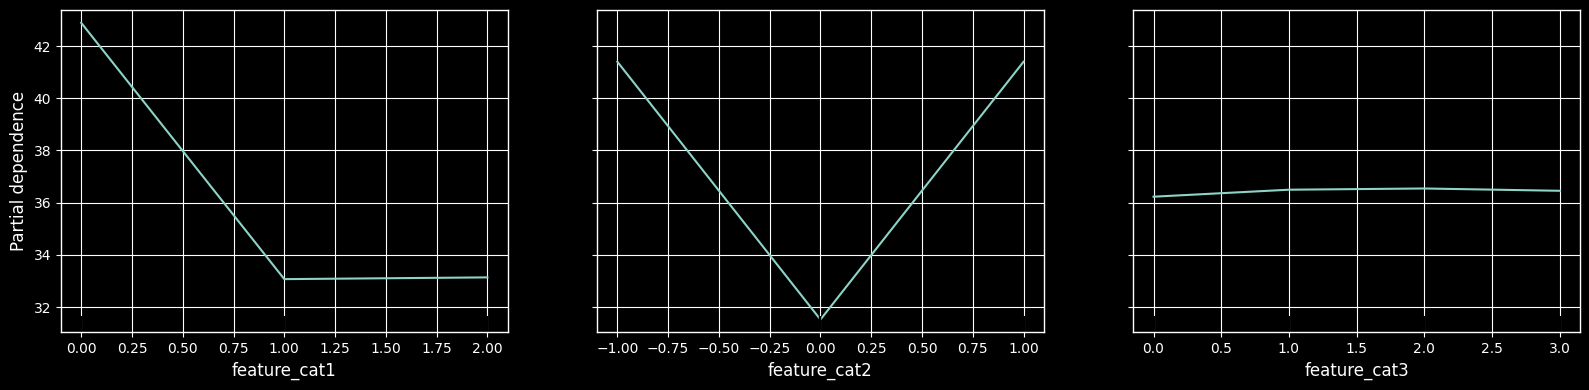

In [72]:
# Encode categorical features as codes
X_test_pdp = dset.X_test.copy()
for col in categorical_features:
    X_test_pdp[col] = X_test_pdp[col].cat.codes

fig, ax = plt.subplots(figsize=(16, 4))

PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_test_pdp,
    features=categorical_features,  # or use index
    grid_resolution=10,
    ax=ax
)
plt.tight_layout()
plt.show()

> 2d

<Figure size 800x600 with 0 Axes>

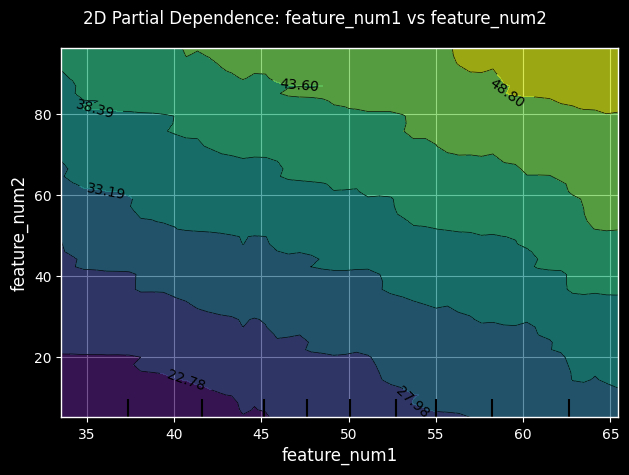

In [74]:
# Define the pair of features you want to analyze
features_2d = [('feature_num1', 'feature_num2')]

# Plot the 2D partial dependence
fig = plt.figure(figsize=(8, 6))

PartialDependenceDisplay.from_estimator(
    xgb_model,            # your fitted XGBRegressor
    X_test_pdp,           # raw DataFrame used for fitting
    features=features_2d,
    grid_resolution=50,
    kind='average',       # default: marginal effect
)

plt.suptitle("2D Partial Dependence: feature_num1 vs feature_num2")
plt.tight_layout()
plt.show()

# testing utils on binary classification

In [81]:
df2 = df.copy()
df2.target = (df2.target > df2.target.median()).astype(int)
df2.target.value_counts()

target
1    5000
0    5000
Name: count, dtype: int64

In [82]:
from xgb_dset import XgboostDataset

dset = XgboostDataset(df2, targ_col='target', id_cols=[])
dset.prep_for_tuning(split_type='temporal', p_train=0.8, p_valid=0.1)
dset.prep_for_final_training()

# Check sizes
print(f"Train: {len(dset.X_train)} samples")
print(f"Validation: {len(dset.X_valid)} samples")
print(f"Test: {len(dset.X_test)} samples")

Train: 8000 samples
Validation: 1000 samples
Test: 1000 samples


In [96]:
from xgb_optuning import XGBoostOptunaTuner

tuner = XGBoostOptunaTuner(dset.X_train, dset.y_train, dset.X_valid, dset.y_valid, problem_type='binary')
study = tuner.optimize(total_tune_time=10, print_secs=10)

print(tuner.tuned_params)

Elapsed: 13.0sec | Iteration #6
{'max_depth': 11, 'learning_rate': 0.06054365855469246, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'lambda': 8.123245085588687, 'min_child_weight': 17.151524893607167, 'n_estimators': 121}


In [97]:
tuner.base_params

{'booster': 'gbtree',
 'verbosity': 0,
 'enable_categorical': True,
 'tree_method': 'hist',
 'objective': 'binary:logistic'}

In [98]:
tuner.training_params

{'booster': 'gbtree',
 'verbosity': 0,
 'enable_categorical': True,
 'tree_method': 'hist',
 'objective': 'binary:logistic',
 'max_depth': 11,
 'learning_rate': 0.06054365855469246,
 'subsample': 0.8540362888980227,
 'colsample_bytree': 0.5102922471479012,
 'lambda': 8.123245085588687,
 'min_child_weight': 17.151524893607167,
 'n_estimators': 121}

In [100]:
from xgboost import XGBClassifier
from ml_evals import ClassificationEvals

# Wrap the model as an XGBRegressor from sklearn
xgb_model = XGBClassifier(**tuner.training_params) # enable cats and hist already included
xgb_model.fit(dset.X_trainvalid, dset.y_trainvalid) 

# predict on test set
preds_test = xgb_model.predict(dset.X_test)
preds_train = xgb_model.predict(dset.X_trainvalid)

# Evaluate
train_evals = ClassificationEvals(dset.y_trainvalid, preds_train)
test_evals  = ClassificationEvals(dset.y_test, preds_test)

print('train')
display(train_evals.assemble_results_df())
print('test')
display(test_evals.assemble_results_df())

train


,f1,recall,precision,accuracy
0,0.885666,0.885173,0.886161,0.886111


test


,f1,recall,precision,accuracy
0,0.862439,0.858252,0.866667,0.859


# check with linear models

In [146]:
from linear_dset import LinearDataset

lin_dset = LinearDataset(df, targ_col='target', id_cols=[])
lin_dset.prep_for_tuning(split_type='temporal', p_train=0.8, p_valid=0.1)
lin_dset.prep_for_final_training()

# Check sizes
print(f"Train: {len(lin_dset.X_train)} samples")
print(f"Validation: {len(lin_dset.X_valid)} samples")
print(f"Test: {len(lin_dset.X_test)} samples")

Train: 8000 samples
Validation: 1000 samples
Test: 1000 samples


> tune and train in a single step

In [147]:
from linear_tune import ridge_grid_search

model, alpha, score, results = ridge_grid_search(lin_dset.X_train, 
                                                 lin_dset.y_train, 
                                                 lin_dset.X_valid, 
                                                 lin_dset.y_valid)

print(f"Best alpha: {alpha}")


train_preds = model.predict(lin_dset.X_trainvalid)
test_preds  = model.predict(lin_dset.X_test)


# Evaluate
train_evals = ContinuousEvals(lin_dset.y_trainvalid, train_preds)
test_evals  = ContinuousEvals(lin_dset.y_test,       test_preds)

print('train')
display(train_evals.assemble_results_df())
print('test')
display(test_evals.assemble_results_df())

Best alpha: 100.0
train


,rmse,rmse_over_mean,mae,mae_over_mean,ave_bias,total_bias
0,5.056512,0.140243,3.992959,0.110745,0.02098,188.821203


test


,rmse,rmse_over_mean,mae,mae_over_mean,ave_bias,total_bias
0,5.124275,0.140243,4.123349,0.112849,-0.043473,-43.473019


In [138]:
from linear_dset import LinearDataset

lin_dset = LinearDataset(df2, targ_col='target', id_cols=[])
lin_dset.prep_for_tuning(split_type='temporal', p_train=0.8, p_valid=0.1)
lin_dset.prep_for_final_training()

# Check sizes
print(f"Train: {len(lin_dset.X_train)} samples")
print(f"Validation: {len(lin_dset.X_valid)} samples")
print(f"Test: {len(lin_dset.X_test)} samples")

Train: 8000 samples
Validation: 1000 samples
Test: 1000 samples


In [145]:
from linear_tune import logistic_ridge_grid_search

model, best_C, best_loss, all_results = logistic_ridge_grid_search(  lin_dset.X_train, 
                                                                     lin_dset.y_train, 
                                                                     lin_dset.X_valid, 
                                                                     lin_dset.y_valid)

print(f"Best C: {best_C}")

train_preds = model.predict(lin_dset.X_trainvalid)
test_preds  = model.predict(lin_dset.X_test)


# Evaluate
train_evals = ClassificationEvals(lin_dset.y_trainvalid, train_preds)
test_evals  = ClassificationEvals(lin_dset.y_test,       test_preds)

print('train')
display(train_evals.assemble_results_df())
print('test')
display(test_evals.assemble_results_df())

Best C: 1.0
train


,f1,recall,precision,accuracy
0,0.873856,0.872687,0.875028,0.874444


test


,f1,recall,precision,accuracy
0,0.877193,0.873786,0.880626,0.874
